<img src="https://github.com/Sengsathit/OCR_data_scientist_assets/blob/main/header_olist.png?raw=true" alt="Alternative text" />

**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
- [Initialisation](#toc2_)    
  - [Importations et configurations](#toc2_1_)    
  - [Chargement des données](#toc2_2_)    
- [Modélisation](#toc3_)    
  - [Fonctions ré-utilisables](#toc3_1_)    
  - [Évaluation des modèles d'apprentissage](#toc3_2_)    
    - [Sélection des données](#toc3_2_1_)    
    - [Standardisation des données](#toc3_2_2_)    
    - [Évaluation du modèle K-means](#toc3_2_3_)    
    - [Évaluation du modèle DBSCAN](#toc3_2_4_)    
    - [Évaluation du modèle de clustering hiérarchique](#toc3_2_5_)    
  - [Clustering avec K-means](#toc3_3_)    
    - [Entraînement du modèle](#toc3_3_1_)    
- [Analyse du clustering](#toc4_)    
  - [Fonctions ré-utilisables](#toc4_1_)    
  - [Analyse de la récence du dernier achat](#toc4_2_)    
    - [Analyse détaillée de la récence par cluster](#toc4_2_1_)    
      - [Récence cluster 0](#toc4_2_1_1_)    
      - [Récence cluster 1](#toc4_2_1_2_)    
      - [Récence cluster 2](#toc4_2_1_3_)    
      - [Récence cluster 3](#toc4_2_1_4_)    
      - [Récence cluster 4](#toc4_2_1_5_)    
  - [Analyse des fréquences d'achats](#toc4_3_)    
  - [Analyse des montants dépensés](#toc4_4_)    
  - [Analyse de la satisfaction client](#toc4_5_)    
    - [Satisfactions globale](#toc4_5_1_)    
    - [Satisfactions détaillées](#toc4_5_2_)    
- [Résumé de la segmentation](#toc5_)    
  - [Les personae](#toc5_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Introduction](#toc0_)

L'objectif de ce notebook est d'analyser les profils clients en fonction de leur comportement d'achat et de leur satisfaction. Pour ce faire, nous évaluons plusieurs modèles d'apprentissage non supervisés afin de sélectionner le plus performant dans la segmentation des clients.

# <a id='toc2_'></a>[Initialisation](#toc0_)

## <a id='toc2_1_'></a>[Importations et configurations](#toc0_)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

# Configurer Pandas pour un affichage complet du contenu des colonnes
#pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.rcParams['figure.facecolor'] = '#FFFCF7'    # Définir la couleur de fond de la figure
plt.rcParams['axes.facecolor'] = '#FFFCF7'      # Définir la couleur de fond des axes

/var/folders/59/q0j81gmx5h7gvpg38k8hknzw0000gn/T/ipykernel_15504/1754057025.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## <a id='toc2_2_'></a>[Chargement des données](#toc0_)

Les données proviennent du dataset construit durant la phase exploratoire où nous avons effectué l'extraction des données de la base de données, l'agrégation de ces données ainsi que le feature engineering.

In [2]:
df = pd.read_csv('../datasets/olist.csv')

# <a id='toc3_'></a>[Modélisation](#toc0_)

Dans cette partie nous nous concentrons sur le choix des features et le choix du modèle qui vont nous permettre d'effectuer le clustering.

## <a id='toc3_1_'></a>[Fonctions ré-utilisables](#toc0_)

In [3]:
def evaluate_kmeans(data_scaled: np.ndarray, df_name: str, title: str):
    """
    Évalue les performances de la méthode K-means pour différents nombres de clusters et affiche les résultats.

    Args:
    data_scaled (np.ndarray): Données normalisées pour l'algorithme K-means.
    df_name (str): Nom du DataFrame pour sauvegarder le graphique.
    title (str): Titre du graphique.

    Returns:
    None
    """

    k_range = range(2, 10)      # Plage de valeurs pour le nombre de clusters
    inertias = []               # Inerties calculées à afficher
    silhouette_scores = []      # Scores de silhouette à afficher
    davies_bouldin_scores = []  # Indices de Davies-Bouldin à afficher

    # Boucle sur les différentes valeurs de k
    for k in k_range:
        # Application de l'algorithme K-means
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data_scaled)
        
        # Calcul de l'inertie
        inertia = kmeans.inertia_
        inertias.append(inertia)
        
        # Calcul du score de silhouette
        silhouette = silhouette_score(data_scaled, kmeans.labels_, random_state=42)
        silhouette_scores.append(silhouette)
        
        # Calcul de l'indice de Davies-Bouldin
        davies_bouldin = davies_bouldin_score(data_scaled, kmeans.labels_)
        davies_bouldin_scores.append(davies_bouldin)

    # Création des sous-graphiques pour afficher les résultats
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(title, fontsize=16)

    # Méthode du coude
    axs[0].plot(k_range, inertias, marker='o', c='r')
    axs[0].set_title('Méthode du coude')
    axs[0].set_xlabel('Nombre de clusters')
    axs[0].set_ylabel('Inertie')

    # Davies-Bouldin
    axs[1].plot(k_range, davies_bouldin_scores, marker='o', c='b')
    axs[1].set_title('Davies-Bouldin Score')
    axs[1].set_xlabel('Nombre de clusters')
    axs[1].set_ylabel('Indice Davies-Bouldin')
    for i, txt in enumerate(davies_bouldin_scores):
        axs[1].annotate(f'{txt:.2f}', (k_range[i], davies_bouldin_scores[i]), textcoords="offset points", xytext=(0, 10), ha='center')

    # Silhouette
    axs[2].plot(k_range, silhouette_scores, marker='o', c='g')
    axs[2].set_title('Silhouette Score')
    axs[2].set_xlabel('Nombre de clusters')
    axs[2].set_ylabel('Coefficient de Silhouette')
    for i, txt in enumerate(silhouette_scores):
        axs[2].annotate(f'{txt:.2f}', (k_range[i], silhouette_scores[i]), textcoords="offset points", xytext=(0, 10), ha='center')

    # Affichage
    plt.tight_layout()
    plt.savefig(f"../images/kmeans_evaluation_{df_name}.png")
    plt.show()

In [4]:
def evaluate_dbscan(data_scaled: np.ndarray, df_name: str, title: str):
    """
    Évalue les performances de l'algorithme DBSCAN pour différentes valeurs de epsilon et affiche les résultats.

    Args:
    data_scaled (np.ndarray): Données normalisées pour l'algorithme DBSCAN.
    df_name (str): Nom du DataFrame pour sauvegarder le graphique.
    title (str): Titre du graphique.

    Returns:
    None
    """
    
    eps_range = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0]  # Intervalle de valeurs pour le paramètre epsilon
    min_samples = 5                             # Nombre minimum de points requis pour former un cluster   
    silhouette_scores = []                      # Scores de silhouette à afficher
    davies_bouldin_scores = []                  # Indices de Davies-Bouldin à afficher
    num_clusters = []                           # Nombre de clusters testés pour les différentes valeurs d'epsilon

    # Boucle sur les différentes valeurs de eps
    for eps in eps_range:
        # Application de l'algorithme DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = dbscan.fit_predict(data_scaled)

        # Évaluation des scores si plus d'un cluster est détecté
        if len(set(labels)) > 1:  # Éviter les cas où tous les points sont des bruits
            silhouette = silhouette_score(data_scaled, labels)
            davies_bouldin = davies_bouldin_score(data_scaled, labels)
        else:
            silhouette = -1
            davies_bouldin = np.inf
        
        silhouette_scores.append(silhouette)
        davies_bouldin_scores.append(davies_bouldin)
        num_clusters.append(len(set(labels)) - (1 if -1 in labels else 0))  # Ne pas compter le bruit comme un cluster

    # Création des sous-graphiques pour afficher les résultats
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(title, fontsize=16)

    # Nombre de clusters
    axs[0].plot(eps_range, num_clusters, marker='o', c='r')
    axs[0].set_title('Nombre de clusters')
    axs[0].set_xlabel('Valeur de eps')
    axs[0].set_ylabel('Nombre de clusters')

    # Davies-Bouldin
    axs[1].plot(eps_range, davies_bouldin_scores, marker='o', c='b')
    axs[1].set_title('Davies-Bouldin Score')
    axs[1].set_xlabel('Valeur de eps')
    axs[1].set_ylabel('Indice Davies-Bouldin')
    for i, txt in enumerate(davies_bouldin_scores):
        if txt != np.inf:
            axs[1].annotate(f'{txt:.2f}', (eps_range[i], davies_bouldin_scores[i]), textcoords="offset points", xytext=(0, 10), ha='center')

    # Silhouette
    axs[2].plot(eps_range, silhouette_scores, marker='o', c='g')
    axs[2].set_title('Silhouette Score')
    axs[2].set_xlabel('Valeur de eps')
    axs[2].set_ylabel('Coefficient de Silhouette')
    for i, txt in enumerate(silhouette_scores):
        if txt != -1:
            axs[2].annotate(f'{txt:.2f}', (eps_range[i], silhouette_scores[i]), textcoords="offset points", xytext=(0, 10), ha='center')

    plt.tight_layout()
    plt.savefig(f"../images/dbscan_evaluation_{df_name}.png")
    plt.show()

In [5]:
def evaluate_ahc(data_scaled: np.ndarray, df_name: str, title: str):
    """
    Évalue les performances de l'algorithme de clustering hiérarchique agglomératif pour différents nombres de clusters et affiche les résultats.

    Args:
    data_scaled (np.ndarray): Données normalisées pour l'algorithme de clustering hiérarchique.
    df_name (str): Nom du DataFrame pour sauvegarder le graphique.
    title (str): Titre du graphique.

    Returns:
    None
    """
    
    k_range = range(2, 10)      # Plage de valeurs pour le nombre de clusters
    silhouette_scores = []      # Scores de silhouette à afficher
    davies_bouldin_scores = []  # Indices de Davies-Bouldin à afficher

    # Boucle sur les différentes valeurs de k
    for k in k_range:

        # Application de l'algorithme de clustering hiérarchique agglomératif
        hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
        labels = hierarchical.fit_predict(data_scaled)
        
        # Calcul du score de silhouette
        silhouette = silhouette_score(data_scaled, labels)
        silhouette_scores.append(silhouette)
        
        # Calcul de l'indice de Davies-Bouldin
        davies_bouldin = davies_bouldin_score(data_scaled, labels)
        davies_bouldin_scores.append(davies_bouldin)

    # Création des sous-graphiques pour afficher les résultats
    fig, axs = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle(title, fontsize=16)

    # Davies-Bouldin
    axs[0].plot(k_range, davies_bouldin_scores, marker='o', c='b')
    axs[0].set_title('Davies-Bouldin Score')
    axs[0].set_xlabel('Nombre de clusters')
    axs[0].set_ylabel('Indice Davies-Bouldin')
    for i, txt in enumerate(davies_bouldin_scores):
        axs[0].annotate(f'{txt:.2f}', (k_range[i], davies_bouldin_scores[i]), textcoords="offset points", xytext=(0, 10), ha='center')

    # Silhouette
    axs[1].plot(k_range, silhouette_scores, marker='o', c='g')
    axs[1].set_title('Silhouette Score')
    axs[1].set_xlabel('Nombre de clusters')
    axs[1].set_ylabel('Coefficient de Silhouette')
    for i, txt in enumerate(silhouette_scores):
        axs[1].annotate(f'{txt:.2f}', (k_range[i], silhouette_scores[i]), textcoords="offset points", xytext=(0, 10), ha='center')

    plt.tight_layout()
    plt.savefig(f"../images/ahc_evaluation_{df_name}.png")
    plt.show()

## <a id='toc3_2_'></a>[Évaluation des modèles d'apprentissage](#toc0_)

### <a id='toc3_2_1_'></a>[Sélection des données](#toc0_)

Les features qui semblent pertinents pour le clustering sont :

- recency = récence du dernier achat
- frequency = nombre d'achats effectués par mois
- monetary = total des sommes dépensées
- orders_total = nombre total de commandes
- products_per_order = nombre de produits par commande
- average_basket = panier moyen par client
- nb_product_categories = nombre de catégories de produits commandés par le client
- satisfaction = moyenne des avis par client

À partir de ces features, nous constituons deux ensembles de données :
- X_default regroupe l'ensemble des features
- X_rfm ne contient que les features liées à la récence du dernier achat, à la fréquence des achats, au montant total dépensé et la satisfaction client.

L'objectif étant de déterminer quel ensemble nous permet d'avoir les meilleurs résultats lors du clustering.

In [6]:
X_default = df[['recency', 'frequency', 'monetary', 'orders_total', 'products_total', 'products_per_order', 'average_basket', 'nb_product_categories', 'satisfaction']].copy()
X_rfm = df[['recency', 'frequency', 'monetary','satisfaction']].copy()

### <a id='toc3_2_2_'></a>[Standardisation des données](#toc0_)

Afin de garantir les performances des modèles nous standardisons les données que nous allons tester.

In [7]:
X_default_scaled = StandardScaler().fit_transform(X_default)
X_rfm_scaled = StandardScaler().fit_transform(X_rfm)

### <a id='toc3_2_3_'></a>[Évaluation du modèle K-means](#toc0_)

Nous utilisons le modèle K-means pour déterminer l'ensemble de données et le nombre de clusters offrant les meilleures performances pour la segmentation. 

Le jeu de données RFM avec les avis des clients semble optimal pour le clustering. Ces features permettent à elles seules d'interpréter les comportements d'achat et la statisfaction des clients.\
Nous testons également par la suite cet ensemble avec d'autres modèles (DBSCAN, clustering hiérarchique) pour identifier le modèle le plus adéquat.

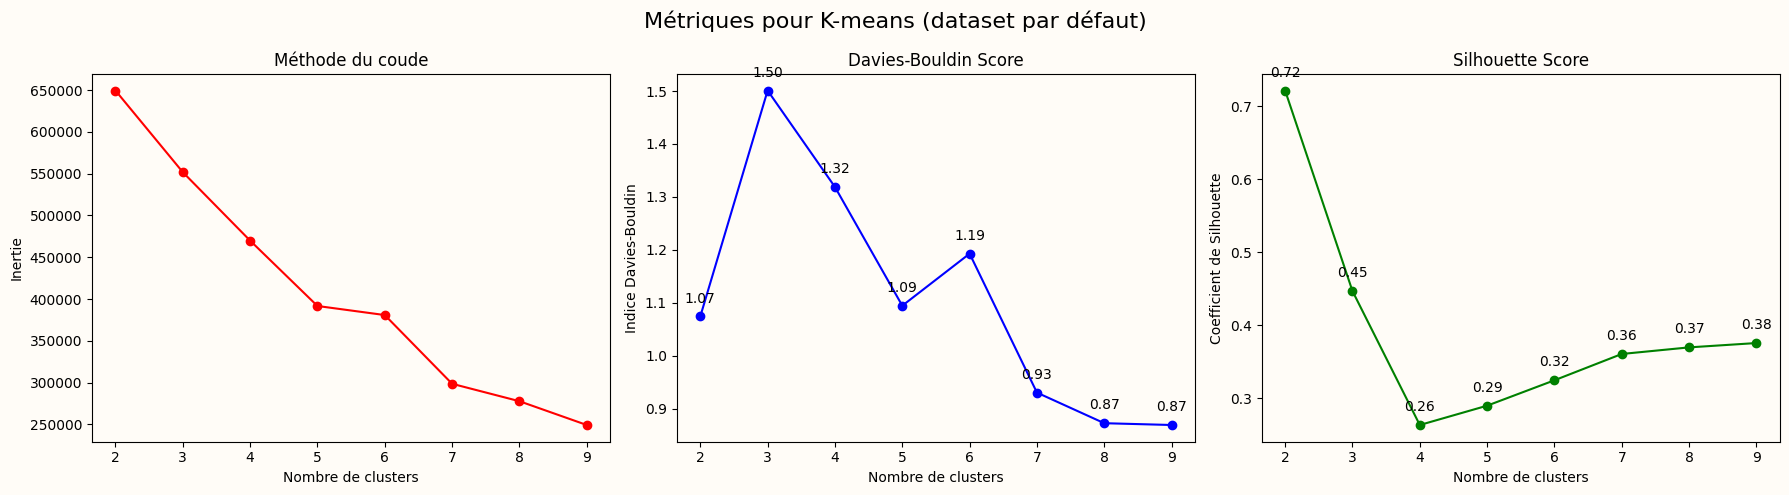

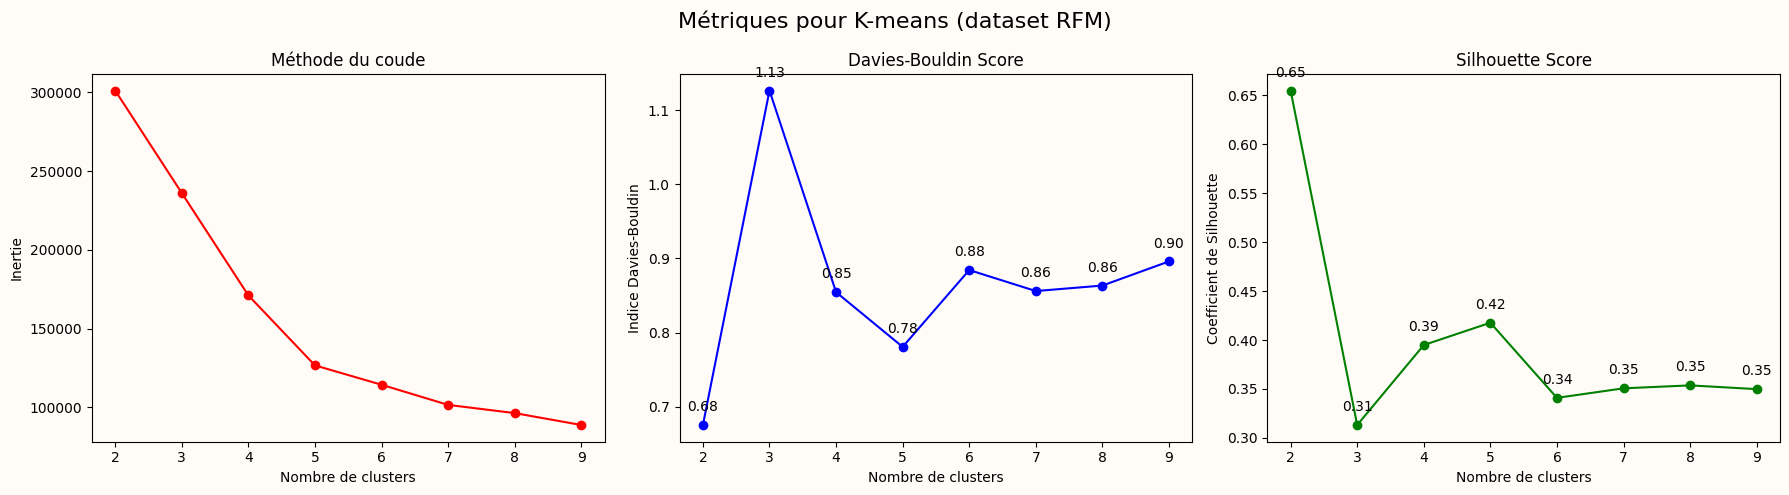

In [8]:
evaluate_kmeans(data_scaled=X_default_scaled, df_name='X_default', title='Métriques pour K-means (dataset par défaut)')
evaluate_kmeans(data_scaled=X_rfm_scaled, df_name='X_rfm', title='Métriques pour K-means (dataset RFM)')

### <a id='toc3_2_4_'></a>[Évaluation du modèle DBSCAN](#toc0_)

Le modèle DBSCAN indique, comme le K-means, que le nombre optimal de clusters est de 5.\
Il présente une valeur minimale du Davies-Bouldin plus élevée que pour le K-means à nombre de cluster équivalent, ainsi qu'un score de silhouette plus important dans les mêmes conditions.

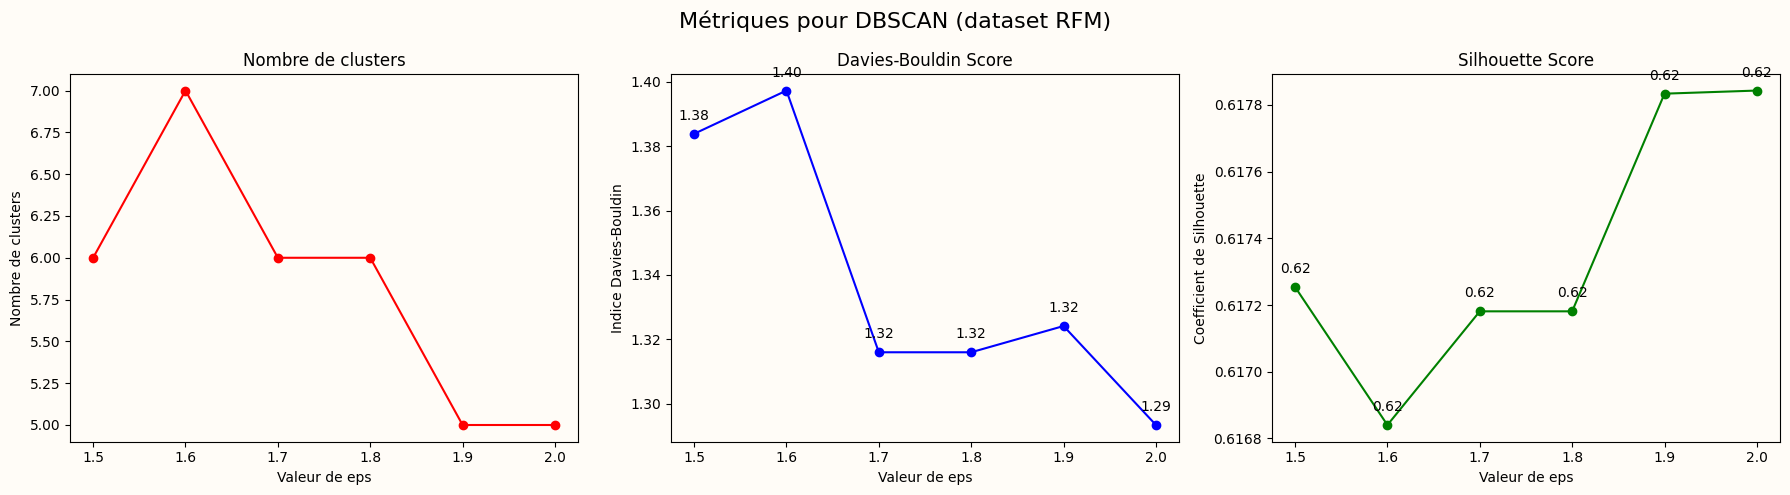

In [9]:
evaluate_dbscan(data_scaled=X_rfm_scaled, df_name='X_rfm', title='Métriques pour DBSCAN (dataset RFM)')

### <a id='toc3_2_5_'></a>[Évaluation du modèle de clustering hiérarchique](#toc0_)

Le modèle hiérarchique indique, comme le K-means, que le nombre optimal de clusters est de 5.\
Il présente une valeur minimale du Davies-Bouldin équivalent au K-means à nombre de cluster équivalent mais un score de silhouette plus faible.

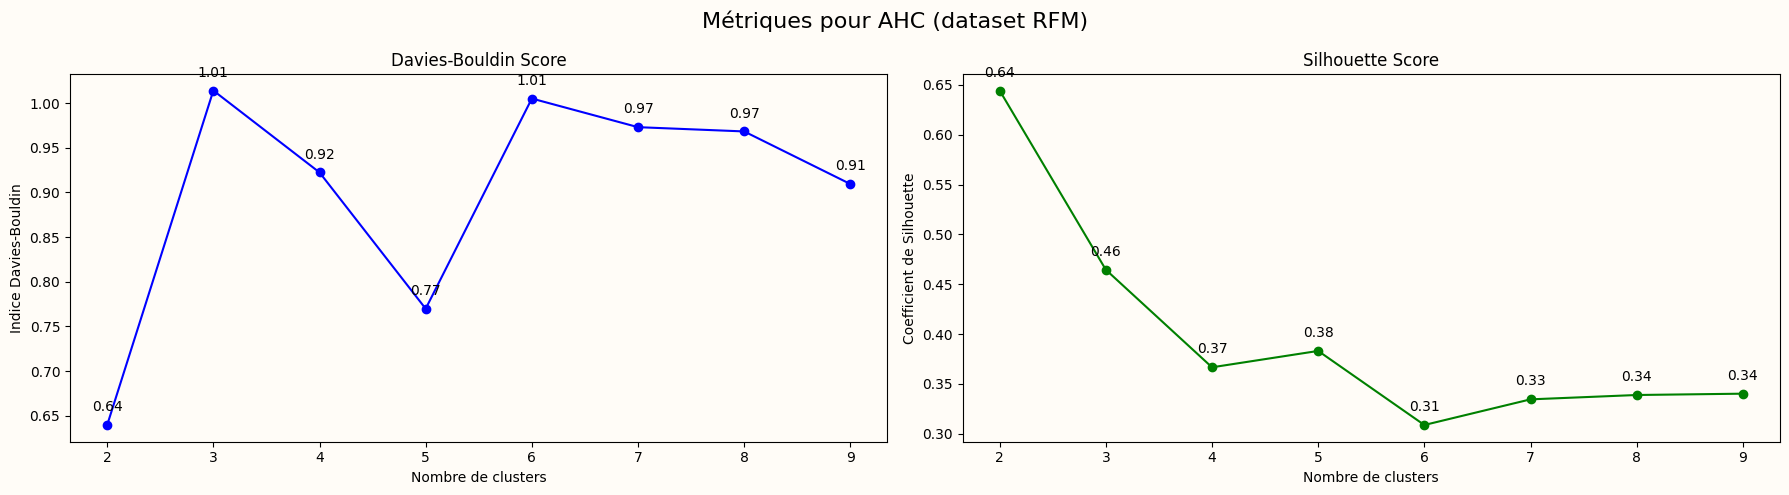

In [10]:
observations_rate = 35
observations = round(X_rfm_scaled.shape[0] * observations_rate / 100)
data_scaled = X_rfm_scaled[:observations,:]
evaluate_ahc(data_scaled=data_scaled, df_name='X_rfm', title='Métriques pour AHC (dataset RFM)')

## <a id='toc3_3_'></a>[Clustering avec K-means](#toc0_)

Notre travail de clustering s'appui sur le modèle K-means en considérant une segmentation à 5 clusters et un dataset constitué des features RFM + Statisfaction

### <a id='toc3_3_1_'></a>[Entraînement du modèle](#toc0_)

In [11]:
nb_clusters = 5
kmeans = KMeans(nb_clusters, random_state=42)
kmeans.fit(X_rfm_scaled)

labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

In [12]:
# Préparation d'un nouveau dataframe pour la visualisation
X_rfm_scaled_df = pd.DataFrame(X_rfm_scaled, columns=X_rfm.columns)
X_rfm_scaled_df['cluster'] = labels

# Retenir également les cluster dans le DataFrame initial puis le sauvegarder pour les tâches d'analyse futures
df['cluster'] = labels
df.to_csv('../datasets/olist_clusters.csv', index=False)

# <a id='toc4_'></a>[Analyse du clustering](#toc0_)

## <a id='toc4_1_'></a>[Fonctions ré-utilisables](#toc0_)

In [13]:
def generate_scatterplot(
        ax: plt.Axes,
        data_df: pd.DataFrame, 
        x_values: str, 
        y_values: str, 
        title: str, 
        x_label: str, 
        y_label: str):
    """
    Génère un graphique de dispersion pour visualiser les données groupées par clusters.

    Args:
    ax (plt.Axes): Axe Matplotlib sur lequel tracer le graphique.
    data_df (pd.DataFrame): DataFrame contenant les données à tracer.
    x_values (str): Nom de la colonne pour les valeurs en x.
    y_values (str): Nom de la colonne pour les valeurs en y.
    title (str): Titre du graphique.
    x_label (str): Étiquette de l'axe x.
    y_label (str): Étiquette de l'axe y.

    Returns:
    None
    """
    
    # Tracer un graphique de dispersion avec les points colorés par cluster
    sns.scatterplot(ax=ax, x=x_values, y=y_values, hue='cluster', data=data_df, palette='tab10')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(title="Cluster")


def generate_histplot(
        scaled_df: pd.DataFrame, 
        clusters: list, 
        feature: str, 
        title: str,
        x_label: str, 
        y_label: str,
        x_lim: tuple = None,
        figsize: tuple = (20, 6),
        color: str = None):
    """
    Génère un histogramme pour visualiser la distribution d'une caractéristique selon les clusters.

    Args:
    scaled_df (pd.DataFrame): DataFrame contenant les données normalisées.
    clusters (list): Liste des clusters à inclure dans l'histogramme.
    feature (str): Nom de la caractéristique à tracer.
    title (str): Titre de l'histogramme.
    x_label (str): Étiquette de l'axe x.
    y_label (str): Étiquette de l'axe y.
    x_lim (tuple, optional): Limites des valeurs en x (min, max).
    figsize (tuple, optionnel) : La taille de la figure. Par défaut (20, 6).

    Returns:
    None
    """

    plt.figure(figsize=figsize)

    # Tracer un histogramme pour chaque cluster
    for cluster in clusters:
        sns.histplot(scaled_df.loc[scaled_df['cluster'] == cluster, feature], kde=True, bins=50, label=cluster, color=color, edgecolor=None)

    plt.legend(title="Cluster")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title, fontsize=16)
    plt.xlim(x_lim)
    plt.show()

## <a id='toc4_2_'></a>[Analyse de la récence du dernier achat](#toc0_)

Les clusters 0 et 4 se distinguent en termes de récence. Le cluster 0 a le plus de clients avec une récence élevée, indiquant des achats récents, tandis que le cluster 4 montre des récences moins élevées, représentant des clients ayant effectué des achats il y a longtemps.\
Les trois autres clusters (1, 2, 3) présentent des récences plus étalées, ce qui suggère une distribution plus homogène des dates d'achat parmi ces clients.

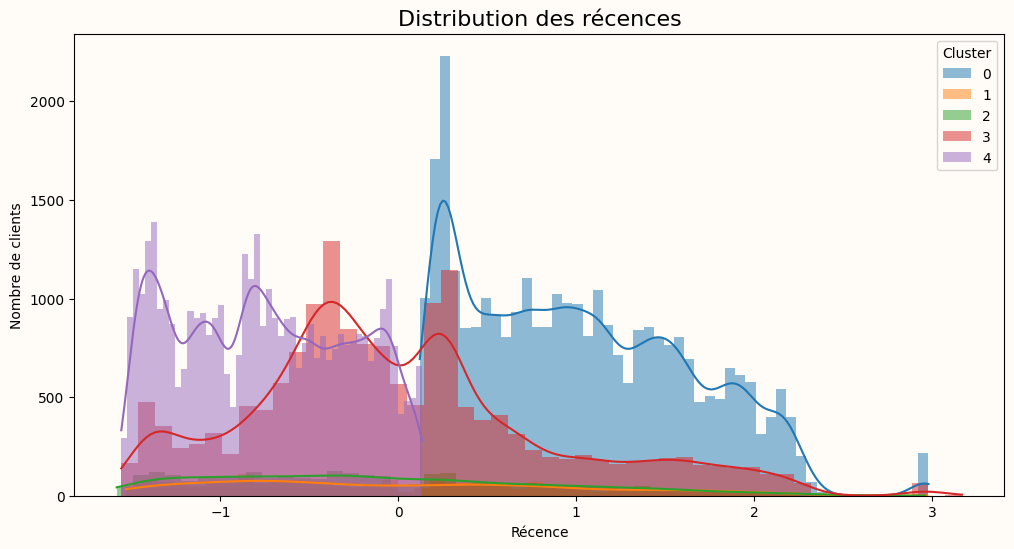

In [14]:
generate_histplot(
    scaled_df=X_rfm_scaled_df, 
    clusters=[0,1,2,3,4], 
    feature='recency', 
    title='Distribution des récences',
    x_label='Récence',
    y_label='Nombre de clients',
    figsize=(12,6)
)

### <a id='toc4_2_1_'></a>[Analyse détaillée de la récence par cluster](#toc0_)

#### <a id='toc4_2_1_1_'></a>[Récence cluster 0](#toc0_)

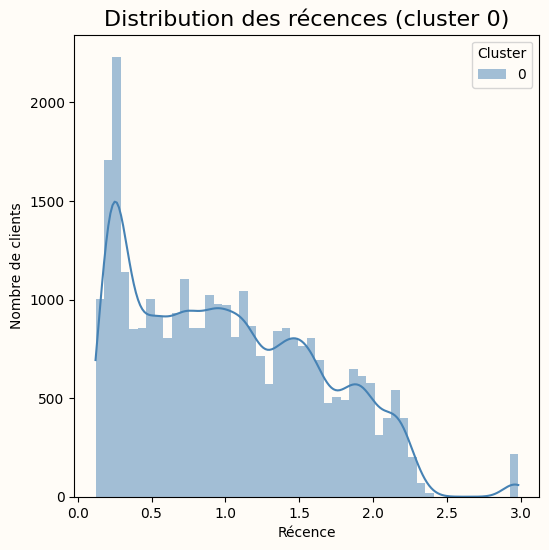

In [15]:
generate_histplot(
    scaled_df=X_rfm_scaled_df, 
    clusters=[0], 
    feature='recency', 
    title='Distribution des récences (cluster 0)',
    x_label='Récence',
    y_label='Nombre de clients',
    color='steelblue',
    figsize=(6,6)
)

#### <a id='toc4_2_1_2_'></a>[Récence cluster 1](#toc0_)

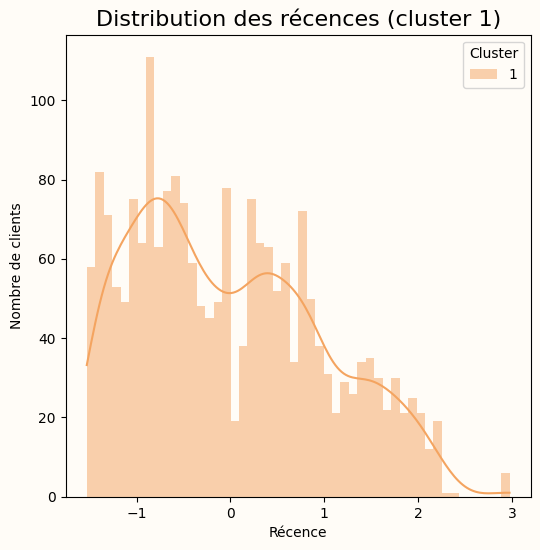

In [16]:
generate_histplot(
    scaled_df=X_rfm_scaled_df, 
    clusters=[1], 
    feature='recency', 
    title='Distribution des récences (cluster 1)',
    x_label='Récence',
    y_label='Nombre de clients',
    color='sandybrown',
    figsize=(6,6)
)

#### <a id='toc4_2_1_3_'></a>[Récence cluster 2](#toc0_)

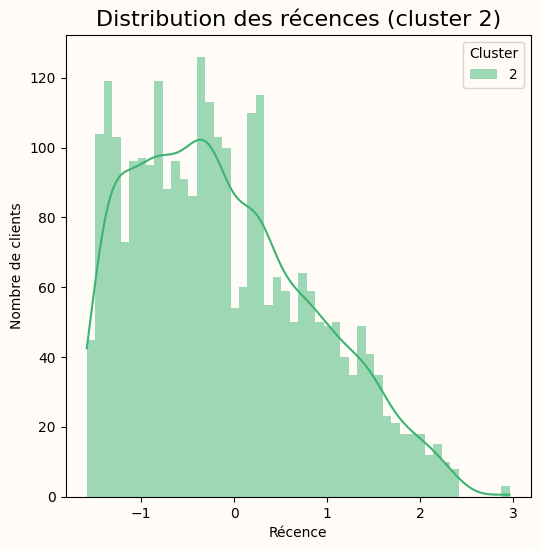

In [17]:
generate_histplot(
    scaled_df=X_rfm_scaled_df, 
    clusters=[2], 
    feature='recency', 
    title='Distribution des récences (cluster 2)',
    x_label='Récence',
    y_label='Nombre de clients',
    color='mediumseagreen',
    figsize=(6,6)
)

#### <a id='toc4_2_1_4_'></a>[Récence cluster 3](#toc0_)

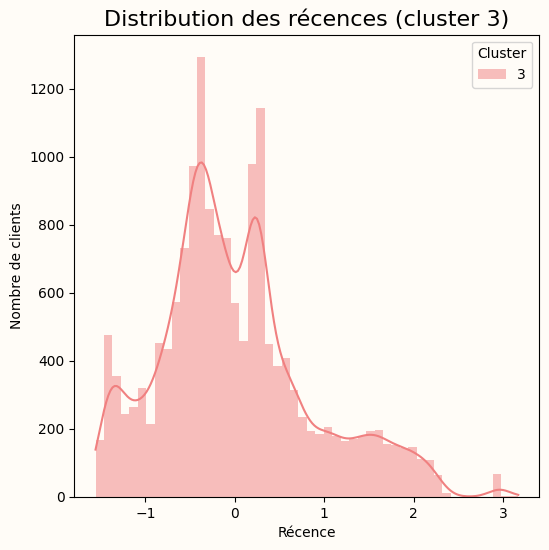

In [18]:
generate_histplot(
    scaled_df=X_rfm_scaled_df, 
    clusters=[3], 
    feature='recency', 
    title='Distribution des récences (cluster 3)',
    x_label='Récence',
    y_label='Nombre de clients',
    color='lightcoral',
    figsize=(6,6)
)

#### <a id='toc4_2_1_5_'></a>[Récence cluster 4](#toc0_)

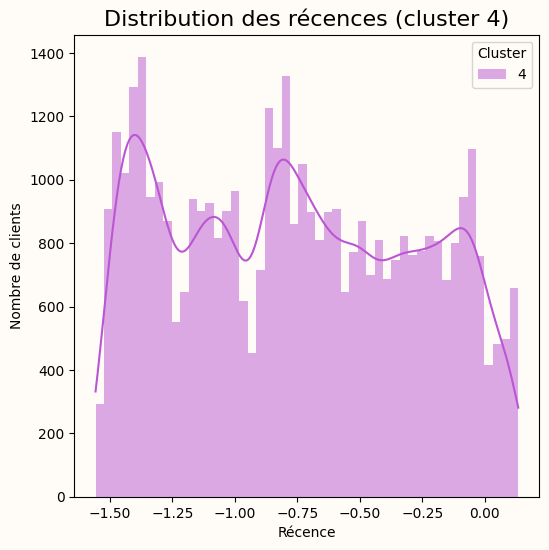

In [19]:
generate_histplot(
    scaled_df=X_rfm_scaled_df, 
    clusters=[4], 
    feature='recency', 
    title='Distribution des récences (cluster 4)',
    x_label='Récence',
    y_label='Nombre de clients',
    color='mediumorchid',
    figsize=(6,6)
)

## <a id='toc4_3_'></a>[Analyse des fréquences d'achats](#toc0_)

Le seul cluster dont les fréquences d'achat se distinguent réellement est le cluster 2. Les clients de ce cluster manifestent une activité d'achat importante, contrairement aux autres clusters où les comportements d'achat sont plus variés.

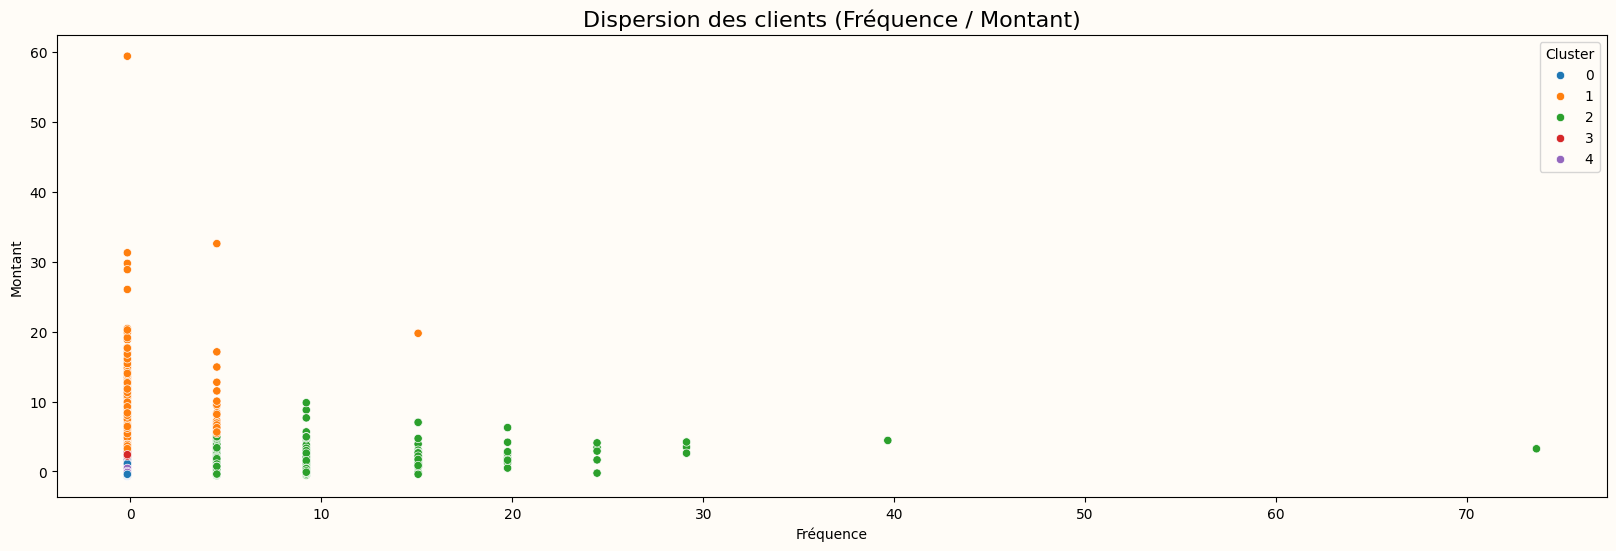

In [20]:
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(111)

generate_scatterplot(ax=ax1, data_df=X_rfm_scaled_df, x_values='frequency', y_values='monetary', title='Dispersion des clients (Fréquence / Montant)', x_label='Fréquence', y_label='Montant')

plt.show()

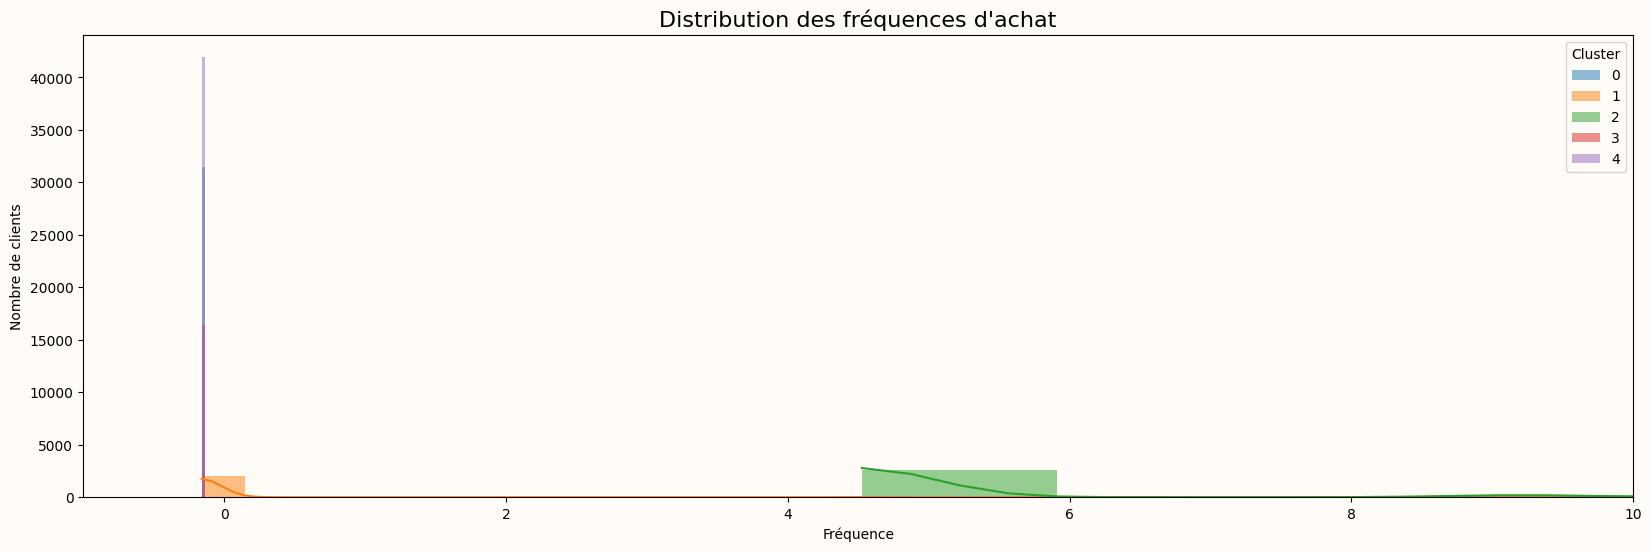

In [21]:
generate_histplot(
    scaled_df=X_rfm_scaled_df, 
    clusters=[0,1,2,3,4], 
    feature='frequency', 
    title='Distribution des fréquences d\'achat',
    x_label='Fréquence',
    y_label='Nombre de clients',
    x_lim=(-1,10)
)

## <a id='toc4_4_'></a>[Analyse des montants dépensés](#toc0_)

Les clients du cluster 1 sont ceux qui dépensent le plus, suivis par les clients du cluster 2, qui ont des dépenses modérées. Les clients des autres clusters (0, 3, et 4) sont les moins dépensiers.

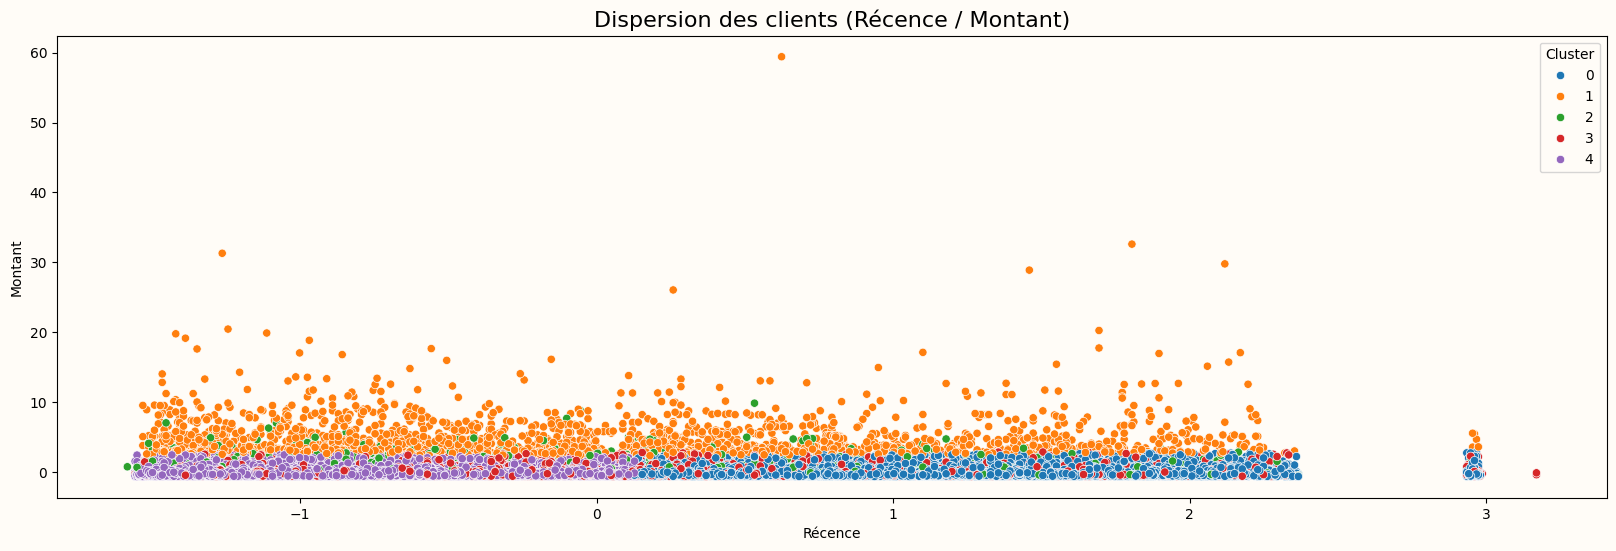

In [22]:
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(111)

generate_scatterplot(ax=ax1, data_df=X_rfm_scaled_df, x_values='recency', y_values='monetary', title='Dispersion des clients (Récence / Montant)', x_label='Récence', y_label='Montant')

plt.show()

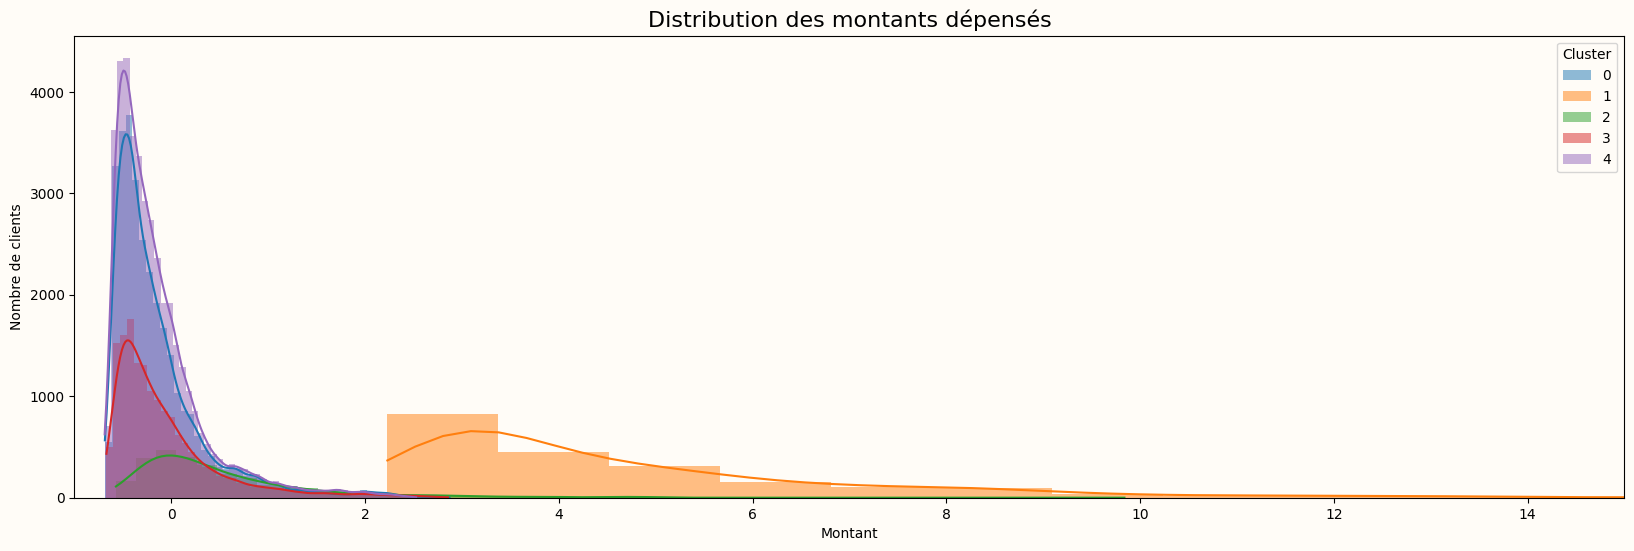

In [23]:
generate_histplot(
    scaled_df=X_rfm_scaled_df, 
    clusters=[0,1,2,3,4], 
    feature='monetary', 
    title='Distribution des montants dépensés',
    x_label='Montant',
    y_label='Nombre de clients',
    x_lim=(-1,15)
)

## <a id='toc4_5_'></a>[Analyse de la satisfaction client](#toc0_)

L'analyse des distributions des avis clients par cluster révèle des niveaux de satisfaction variés.\
Les clusters 0 et 4, avec une forte concentration de scores positifs, suggère deux groupes de clients globalement satisfaits.\
En revanche, les autres clusters montrent des pics à différents niveaux de satisfaction, avec certains clusters affichant des scores négatifs notables, indiquant des poches de mécontentement. 

### <a id='toc4_5_1_'></a>[Satisfactions globale](#toc0_)

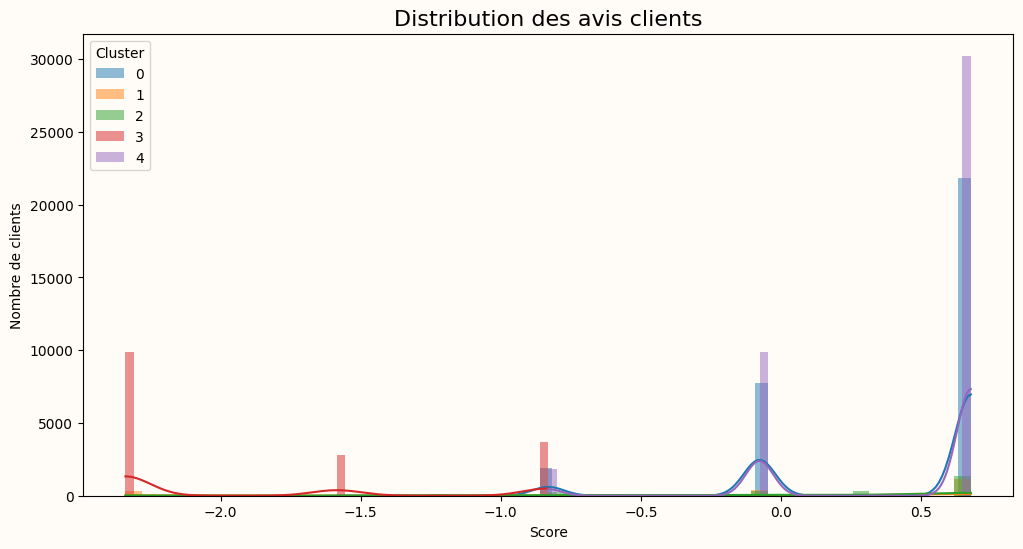

In [24]:
generate_histplot(
    scaled_df=X_rfm_scaled_df, 
    clusters=[0,1,2,3,4], 
    feature='satisfaction', 
    title='Distribution des avis clients',
    x_label='Score',
    y_label='Nombre de clients',
    figsize=(12,6)
)

### <a id='toc4_5_2_'></a>[Satisfactions détaillées](#toc0_)

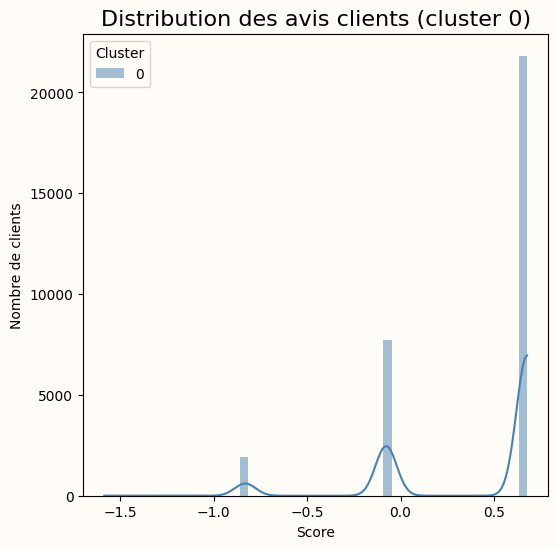

In [25]:
generate_histplot(
    scaled_df=X_rfm_scaled_df, 
    clusters=[0], 
    feature='satisfaction', 
    title='Distribution des avis clients (cluster 0)',
    x_label='Score',
    y_label='Nombre de clients',
    color='steelblue',
    figsize=(6,6)
)

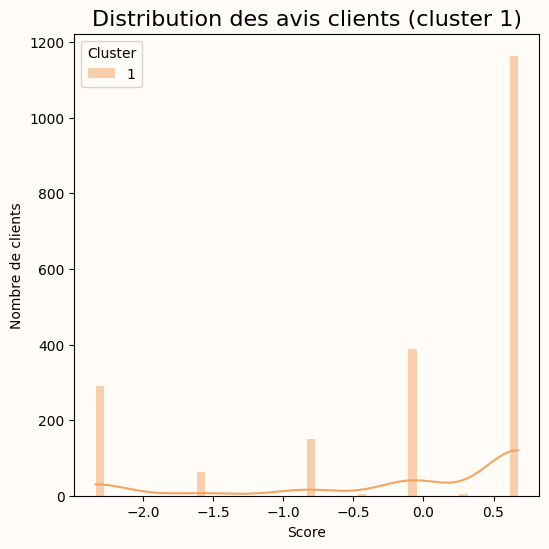

In [26]:
generate_histplot(
    scaled_df=X_rfm_scaled_df, 
    clusters=[1], 
    feature='satisfaction', 
    title='Distribution des avis clients (cluster 1)',
    x_label='Score',
    y_label='Nombre de clients',
    color='sandybrown',
    figsize=(6,6)
)

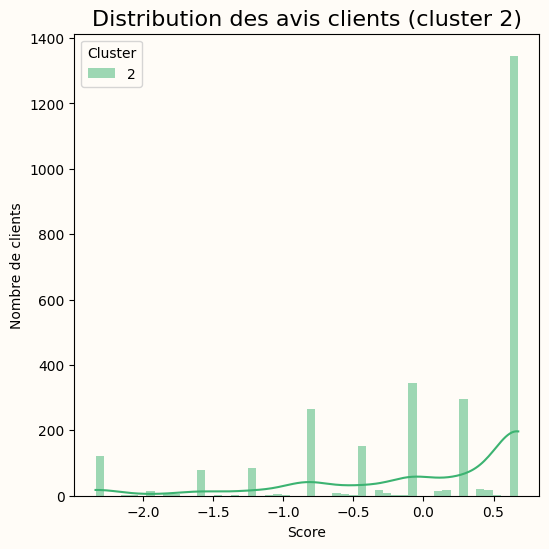

In [27]:
generate_histplot(
    scaled_df=X_rfm_scaled_df, 
    clusters=[2], 
    feature='satisfaction', 
    title='Distribution des avis clients (cluster 2)',
    x_label='Score',
    y_label='Nombre de clients',
    color='mediumseagreen',
    figsize=(6,6)
)

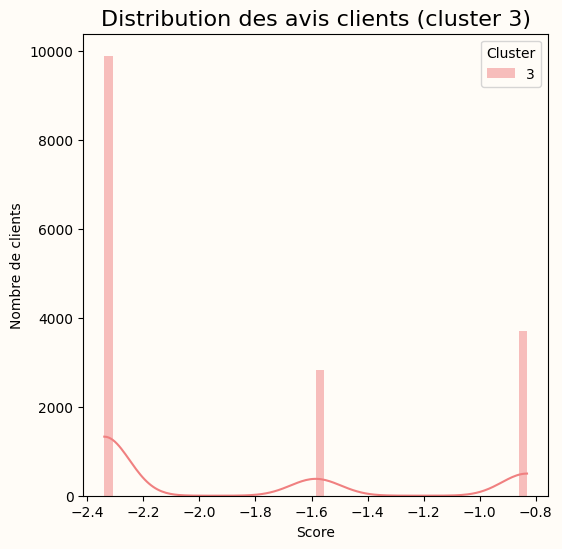

In [28]:
generate_histplot(
    scaled_df=X_rfm_scaled_df, 
    clusters=[3], 
    feature='satisfaction', 
    title='Distribution des avis clients (cluster 3)',
    x_label='Score',
    y_label='Nombre de clients',
    color='lightcoral',
    figsize=(6,6)
)

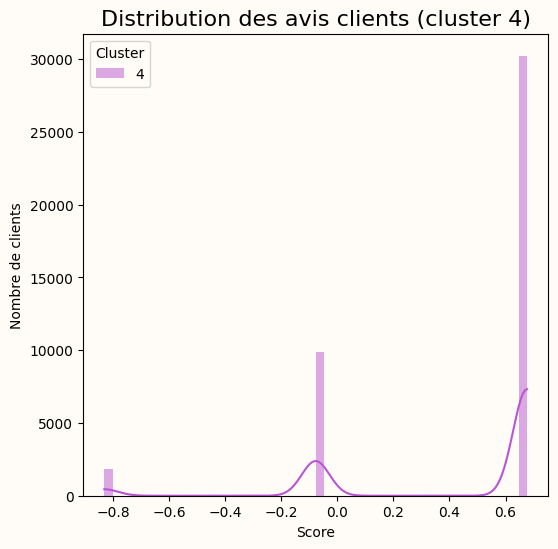

In [29]:
generate_histplot(
    scaled_df=X_rfm_scaled_df, 
    clusters=[4], 
    feature='satisfaction', 
    title='Distribution des avis clients (cluster 4)',
    x_label='Score',
    y_label='Nombre de clients',
    color='mediumorchid',
    figsize=(6,6)
)

# <a id='toc5_'></a>[Résumé de la segmentation](#toc0_)

La répartition des clusters montre que le cluster 4 représente la plus grande proportion de clients (44.26%), suivi du cluster 0 (33.21%) et du cluster 3 (17.35%). Les clusters 1 et 2 ont des proportions beaucoup plus faibles, avec respectivement 2.18% et 3.00% des clients.\
Cette segmentation indique une concentration significative des clients dans quelques clusters spécifiques, suggérant des comportements d'achat distincts et dominants parmi ces groupes.

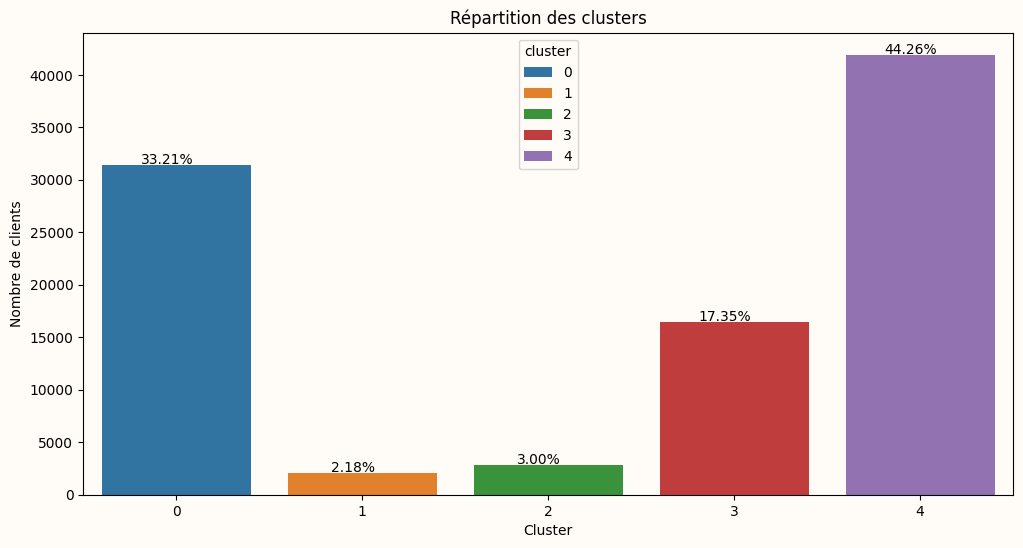

In [30]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=pd.DataFrame(X_rfm_scaled_df['cluster']), x='cluster', hue='cluster', palette='tab10')

# Calculer les pourcentages à afficher au dessus des barres
total = len(X_rfm_scaled_df)
for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height() + 0.001 * total
    if p.get_height() != 0:
        ax.annotate(percentage, (x, y), ha='center')

plt.xlabel('Cluster')
plt.ylabel('Nombre de clients')
plt.title('Répartition des clusters')
plt.show()

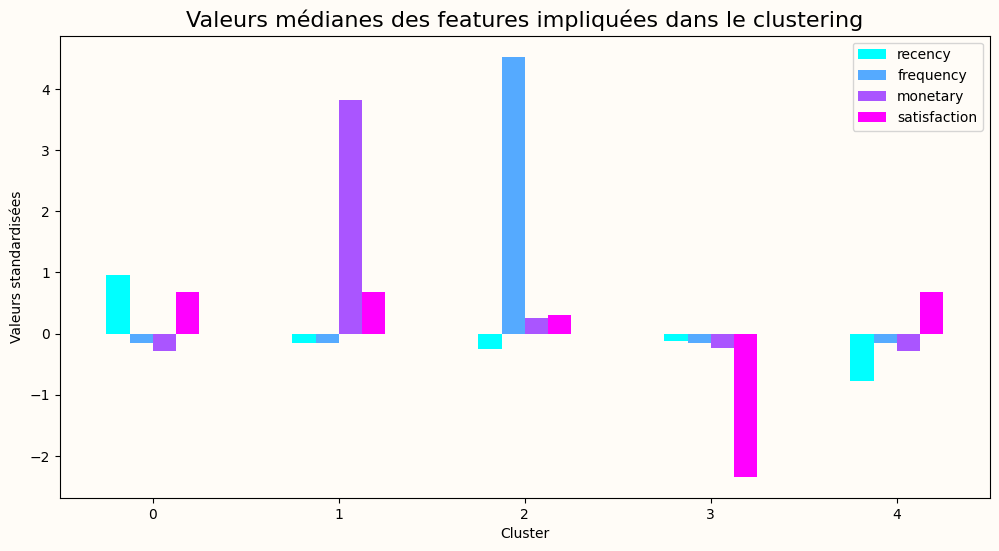

In [31]:
summary = X_rfm_scaled_df.groupby('cluster').agg(['median'])
median_data = summary.xs('median', level=1, axis=1)
median_data.plot(kind='bar', figsize=(12, 6), colormap='cool')

plt.title('Valeurs médianes des features impliquées dans le clustering', fontsize=16)
plt.ylabel('Valeurs standardisées')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

## <a id='toc5_1_'></a>[Les personae](#toc0_)

Les projections des données nous permettent de qualifier 5 profils clients :

**Groupe 1 : Les clients à réengager (cluster 0)**

- Description : Clients dont le dernier achat remonte à une période lointaine (récence élevée).
- Comportement d'achat : Fréquence d'achat et montants dépensés relativement faibles.
- Satisfaction : Avis majoritairement positifs voire très positifs sur leurs achats.
- Qualification : Ce sont des anciens clients qui achètent rarement, mais sont satisfaits de leurs expériences d'achat.

**Groupe 2 : Les clients à fort potentiel (cluster 1)**

- Description : Clients avec une récence modérée.
- Comportement d'achat : Fréquence d'achat modérée et dépenses globalement les plus élevées.
- Satisfaction : Avis moyens dans l'ensemble.
- Qualification : Ce groupe est constitué de clients qui dépense beaucoup et ayant une fréquence d'achat modérée et qui sont globalement satisfaits.

**Groupe 3 :  Les clients ambassadeurs (cluster 2)**

- Description : Clients avec une récence modérée.
- Comportement d'achat : Fréquence d'achat la plus élevée et dépenses modérées parfois élevées.
- Satisfaction : Avis moyens dans l'ensemble.
- Qualification : Ces clients sont les plus actifs, achètent souvent et sont globalement satisfaits.

**Groupe 4 : Les clients désengagés (cluster 3)**

- Description : Clients avec une récence modérée.
- Comportement d'achat : Fréquence d'achat et dépenses relativement faible.
- Satisfaction : Avis majoritairement négatifs sur leurs achats.
- Qualification : Ces clients achètent rarement et dépensent peu et sont généralement insatisfaits de leurs achats.

**Groupe 5 : Les clients récents (cluster 4)**

- Description : Clients ayant acheté récemment.
- Comportement d'achat : Fréquence d'achat et dépenses relativement faible.
- Satisfaction : Avis majoritairement positifs sur leurs achats.
- Qualification : Ce groupe est composé de clients récents dépensant modérément, et qui sont globalement satisfaits de leurs expériences.